In [2]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

#  Import and read the charity_data.csv.
import pandas as pd 
application_df = pd.read_csv("charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


### Preprocessing the Data for a Neural Network 

In [3]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(columns=["EIN","NAME"], axis=1)
application_df.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [4]:
# Determine the number of unique values in each column.
application_df.nunique()

APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

In [5]:
# Look at APPLICATION_TYPE value counts for binning
inc_Amt_counts = application_df.INCOME_AMT.value_counts()
inc_Amt_counts

0                24388
25000-99999       3747
100000-499999     3374
1M-5M              955
1-9999             728
10000-24999        543
10M-50M            240
5M-10M             185
50M+               139
Name: INCOME_AMT, dtype: int64

### Check AST_AMT and bin values if necessary

In [7]:
# Look at ASK_AMT value counts for binning
AMT_counts = application_df.ASK_AMT.value_counts()
AMT_counts

5000        25398
10478           3
15583           3
63981           3
6725            3
            ...  
5371754         1
30060           1
43091152        1
18683           1
36500179        1
Name: ASK_AMT, Length: 8747, dtype: int64

<AxesSubplot:ylabel='Density'>

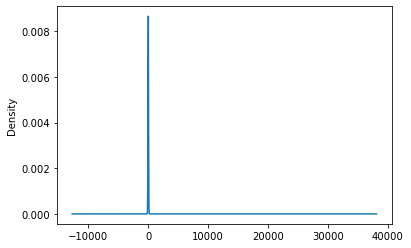

In [8]:
# Visualize the value counts of CLASSIFICATION
AMT_counts.plot.density()

In [10]:
# Determine which values to replace if counts are less than ...?
replace_ask_amt = list(AMT_counts[AMT_counts < 2000].index)

# Replace in dataframe
for amt in replace_ask_amt:
    if amt <= 49999:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt,str("5001-49999"))
    elif amt < 99999:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt,str("50000-99999"))
    elif amt < 499999:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt,str("100000-499999"))
    elif amt < 999999:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt,str("500000-999999"))
    elif amt < 4999999:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt,str("1M-5M"))
    else:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt,str("5M+"))
    
application_df.ASK_AMT = application_df.ASK_AMT.astype(str)

# Check to make sure binning was successful
application_df.ASK_AMT.value_counts()

5000             25398
5001-49999        2947
100000-499999     2305
50000-99999       1421
1M-5M              940
500000-999999      651
5M+                637
Name: ASK_AMT, dtype: int64

In [11]:
application_counts = application_df.APPLICATION_TYPE.value_counts()
application_counts

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

In [12]:
# Determine which values to replace if counts are less than ..?
replace_class = list(application_counts[application_counts < 600].index)

# Replace in dataframe
for app in replace_class:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
application_df.APPLICATION_TYPE.value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
Other      804
T8         737
T7         725
Name: APPLICATION_TYPE, dtype: int64

In [13]:
# Generate our categorical variable lists
application_cat = ["APPLICATION_TYPE", "AFFILIATION", "CLASSIFICATION", "USE_CASE", "ORGANIZATION", "INCOME_AMT", 
                  "SPECIAL_CONSIDERATIONS"]

In [14]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(application_cat)
encode_df.head()

,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [15]:
# Merge one-hot encoded features and drop the originals
application_df = application_df.merge(encode_df,left_index=True, right_index=True)
application_df = application_df.drop(application_cat,1)
application_df.head()

,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,108590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,5000,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,6692,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,142590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [16]:
# Split our preprocessed data into our features and target arrays
y = application_df.IS_SUCCESSFUL
X = application_df.drop("IS_SUCCESSFUL", axis=1)

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

In [17]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [18]:
X_train_scaled.shape

(25724, 43)

In [19]:
# Define the model - deep neural net
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 100
hidden_nodes_layer2 = 30

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))


# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                3520      
                                                                 
 dense_1 (Dense)             (None, 30)                2430      
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 5,981
Trainable params: 5,981
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Compile the Sequential model together and customize metrics
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [22]:
# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

In [23]:
# Create a callback that saves the model's weights every epoch
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch',
    period=5)

# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100,callbacks=[cp_callback])

Epoch 1/100
798/804 [============================>.] - ETA: 0s - loss: 0.5341 - accuracy: 0.7408
Epoch 1: saving model to checkpoints/weights.01.hdf5
804/804 [==============================] - 3s 3ms/step - loss: 0.5344 - accuracy: 0.7406
Epoch 2/100
795/804 [============================>.] - ETA: 0s - loss: 0.5335 - accuracy: 0.7401
Epoch 2: saving model to checkpoints/weights.02.hdf5
804/804 [==============================] - 2s 2ms/step - loss: 0.5341 - accuracy: 0.7399
Epoch 3/100
797/804 [============================>.] - ETA: 0s - loss: 0.5340 - accuracy: 0.7404
Epoch 3: saving model to checkpoints/weights.03.hdf5
804/804 [==============================] - 2s 2ms/step - loss: 0.5342 - accuracy: 0.7400
Epoch 4/100
804/804 [==============================] - ETA: 0s - loss: 0.5335 - accuracy: 0.7397
Epoch 4: saving model to checkpoints/weights.04.hdf5
804/804 [==============================] - 3s 4ms/step - loss: 0.5335 - accuracy: 0.7397
Epoch 5/100
793/804 [=======================

792/804 [============================>.] - ETA: 0s - loss: 0.5317 - accuracy: 0.7410
Epoch 69: saving model to checkpoints/weights.69.hdf5
804/804 [==============================] - 2s 2ms/step - loss: 0.5320 - accuracy: 0.7408
Epoch 70/100
802/804 [============================>.] - ETA: 0s - loss: 0.5324 - accuracy: 0.7412
Epoch 70: saving model to checkpoints/weights.70.hdf5
804/804 [==============================] - 2s 2ms/step - loss: 0.5322 - accuracy: 0.7414
Epoch 71/100
802/804 [============================>.] - ETA: 0s - loss: 0.5320 - accuracy: 0.7401
Epoch 71: saving model to checkpoints/weights.71.hdf5
804/804 [==============================] - 2s 2ms/step - loss: 0.5320 - accuracy: 0.7402
Epoch 72/100
792/804 [============================>.] - ETA: 0s - loss: 0.5322 - accuracy: 0.7406
Epoch 72: saving model to checkpoints/weights.72.hdf5
804/804 [==============================] - 2s 2ms/step - loss: 0.5320 - accuracy: 0.7408
Epoch 73/100
796/804 [===========================

In [24]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 3s - loss: 0.5703 - accuracy: 0.7289 - 3s/epoch - 12ms/step
Loss: 0.5702568888664246, Accuracy: 0.728863000869751


In [27]:
# Export our model to HDF5 file
nn.save("AlphabetSoupCharity.h5")